## In this notebook, two models are built to predict number of patron visits. 

## Concept of the models

    The basic concept of the two models are the same. The models assume that each patron has a rate of dropout after
    each visit. Conditional on not dropping out, the model further assumes that each patron has a rate of visiting the 
    casino.The model allows the dropout rate and visiting rate to be heterogeneously different. 
    
    The models uses historical patron visits data before a given date (calibration period) to predict the number of 
    patron visits during a certain period of time after calibration date (holdout period). 

## Data needed to build the model:

    The data we need to build this model is fairly simple. For each patron that visited the casino during calibration 
    period, we only need the following three pieces of information:
    
        1. Frequency: number of REPEATED VISITS this patron made since first visit (this does not include first visit);
        
        2. Recency: the TIME OF THE MOST RECENT visit this patron made relative of first visit (e.g., if a patron's 
        first visit is on 01-01-2018, and the patron's most recent visit is 02-01-2018, then the time of most recent \
        visit relative of first visit would be 31 days);
        
        3. Age of the patron: a patron's "age" is the duration between a patron's first visit in calibration and the 
        end of calibration). 
    
    A data frame containing these information is called "Customer by Sufficient Statistics matrix" (CBS).

## Data Set-Up:

    Data source: dbo_CDS_StatDay
    Time Frame: 01/01/2018 – 06/10/2019
    Population: Patrons who made at least one visit
    Calibration Period: 01/01/2018 – 12/31/2018
    Holdout Period: 01/01/2019 – 06/10/2019
    
## How the models work:

    For each individual, we know:
    
        Frequency: The number of REPEATED VISITS SINCE FIRST VISIT during calibration period ;
        Recency: The MOST RECENT time of visit relevant of the individual’s first visit during calibration period;
        Age: Time since an individual's first visit till the end of calibration period.

    The model then predicts:
    
        The number of visits this individual will make during holdout period.
        We can arbitrarily change the holdout period and feed this into the model to predict the number of visits 
        this patron would make during holdout period.

## Query used to get the data is shown in the following:

    SELECT dbo_CDS_StatDay.PlayerID, dbo_CDS_StatDay.GamingDate
    FROM dbo_CDS_StatDay
    WHERE dbo_CDS_StatDay.GamingDate >= '2018-01-01' AND dbo_CDS_StatDay.GamingDate <= '2019-06-10'
    GROUP BY dbo_CDS_StatDay.PlayerID, dbo_CDS_StatDay.GamingDate;
    

## Part 1: Intial data processing.
    
    For each patron, group the same-day visits as one visit.
    
    Also find the date of the first visit.
    
    Transform patron visiting data into customer-by-sufficient-statistics matrix (CBS):
       
        .Seperate patron visit record data into calibration and holdout period. 
        .For each patron, identify the patron's calibration period recency, frequency and age.
        .For each patron, identify the patron's holdout period frequency.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

In [8]:
# Read in data from query:

visits = pd.read_csv('visits_by_day_2018.txt',sep = ',')
visits.head()

,PlayerID,GamingDate
0,100033,2018-01-01
1,100038,2018-01-01
2,100084,2018-01-01
3,100101,2018-01-01
4,100107,2018-01-01


In [17]:
df = visits.copy().rename(columns = {'PlayerID':'CustID','GamingDate': 'TransDate'})[['CustID', 'TransDate']]\
           .reset_index(drop = True)
df.to_csv('Cust Transactions.csv')

In [18]:
df

,CustID,TransDate
0,100033,2018-01-01
1,100038,2018-01-01
2,100084,2018-01-01
3,100101,2018-01-01
4,100107,2018-01-01
5,100147,2018-01-01
6,100179,2018-01-01
7,100192,2018-01-01
8,100194,2018-01-01
9,100195,2018-01-01


In [8]:
# Group same-day visits for each patron and get the date of first visit of each patron:

first_visit = visits.groupby(by = 'PlayerID')['GamingDate'].min()\
                    .reset_index()\
                    .rename(columns = {'GamingDate':'FirstVisit'})
player_visits = visits.merge(first_visit, on = 'PlayerID')
player_visits.head()

,PlayerID,GamingDate,FirstVisit
0,100033,2018-01-01,2018-01-01
1,100033,2018-01-04,2018-01-01
2,100033,2018-01-07,2018-01-01
3,100033,2018-01-10,2018-01-01
4,100033,2018-01-11,2018-01-01


In [9]:
# Transform customer visiting records to individual-level calibration and holdout summary data.
# (This is called CBS matrix: Customer-by-Sufficient-Statistic matrix):

from lifetimes.utils import calibration_and_holdout_data
CBS = calibration_and_holdout_data(visits,\
                                   'PlayerID', 'GamingDate', \
                                    calibration_period_end='2018-12-31', \
                                    observation_period_end='2019-06-10' ).reset_index()

CBS = CBS.merge(first_visit, on = 'PlayerID')
CBS.head()

,PlayerID,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,FirstVisit
0,100001,0.0,0.0,327.0,0.0,161,2018-02-07
1,100005,1.0,72.0,193.0,0.0,161,2018-06-21
2,100006,4.0,133.0,268.0,1.0,161,2018-04-07
3,100011,15.0,334.0,336.0,12.0,161,2018-01-29
4,100015,45.0,358.0,361.0,5.0,161,2018-01-04


## Part 2: Fitting a Beta-Geometric NBD (BG/NBD) Model 

### Step 1: Estimate BG/NBD Model parameters.

In [5]:
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import *

bgf = BetaGeoFitter()
pnf = ParetoNBDFitter()

In [6]:
# Estimating parameters of a bg/nbd model based on calibration period data:

bgnbd_model = bgf.fit(CBS['frequency_cal'], CBS['recency_cal'], CBS['T_cal'])
bgnbd_model

<lifetimes.BetaGeoFitter: fitted with 137667 subjects, a: 0.12, alpha: 5.60, b: 0.88, r: 0.28>

### Step 2: Assessing BG/NBD model fitness.

    First, we will generate simulated data with estimated model parameters and see how the model fits on training data. 
    We will count the number of patrons who made repeated number of visits of 0, 1, 2, 3, ..., 40, 40+ times during 
    calibration period repectively, and compare the actual counts to the simulated counts. A bar plot will be used to 
    visulize the comparison. 
    

In [7]:
# Simulate calibration visits based on estimated bg/nbd model parameters:

simulated_bgnbd = bgf.generate_new_data(size = len(CBS))
simulated_bgnbd.head()

,frequency,recency,T,lambda,p,alive
customer_id,,,,,,
0.0,2.0,143.683987,327.0,0.014644,0.000305,1.0
1.0,0.0,0.000000,193.0,0.000072,0.511823,1.0
2.0,0.0,0.000000,268.0,0.007732,0.071182,1.0
3.0,1.0,42.902017,336.0,0.010658,0.600065,0.0
4.0,6.0,251.326267,361.0,0.011490,0.000091,1.0


In [8]:
# Define function to transform individual-level actual calibration and holdout summary data to data frame
# with columns of 'freq' and 'count':

def transform_cal_hold_to_freq_count(df):
    return pd.DataFrame(df['frequency_cal'].value_counts().sort_index())\
                    .reset_index().rename(columns = {'index':'freq','frequency_cal':'count'})

In [9]:
# Define function to transform simulated data to dataframe with columns of 'freq' and 'count':

def transform_sim_to_freq_count(df):
    return pd.DataFrame(df['frequency'].value_counts().\
                        sort_index().reset_index().\
                        rename(columns = {'index': 'freq', 'frequency': 'count'}))

In [10]:
# Define function to bin frequencies for dataframe with columns named 'freq' and 'count':

def binned_max_freq(df,max_x):
    return df.loc[0:max_x].append({'freq':str(max_x) + '+',\
                                   'count':df[df.iloc[:,0] >= max_x].iloc[:,1].sum()},\
                                        ignore_index = True)

In [11]:
# Transform individual-level actual calibration and holdout summary data to data frame (customer by sufficient statistics):

actual_cal_freq = transform_cal_hold_to_freq_count(CBS)

# Transform simulated data to dataframe with columns of 'freq' and 'count':

simulated_cal_freq_bgnbd = transform_sim_to_freq_count(simulated_bgnbd)

In [12]:
# Group transformed actual and simulated data with max frequency of 40:

actual_binned = binned_max_freq(actual_cal_freq, 40)
simulated_binned_bgnbd = binned_max_freq(simulated_cal_freq_bgnbd, 40)

In [48]:
# Merge actual and simulated frequency and count data to get a table that counts the actual number and simulated
# number of patrons who made 0, 1, 2, ..., 40+ repeat transactions during calibration period.
# This table is used to generate the bar plot which show the comparison of actual counts and simulated counts
# of each visit frequency.
# Below shows first five row of this table:

cal_actual_sim_bgnbd = actual_binned.merge(simulated_binned_bgnbd, how = 'outer', on = 'freq')
cal_actual_sim_bgnbd = cal_actual_sim_bgnbd.rename\
            (columns ={'freq':'visits' ,'count_x':'actual_counts','count_y':"simulated_counts"})
cal_actual_sim_bgnbd['visits'] = cal_actual_sim_bgnbd['visits'].astype(str)
cal_actual_sim_bgnbd.head()

,visits,actual_counts,simulated_counts
0,0.0,53840,50676
1,1.0,19275,22989
2,2.0,10242,10684
3,3.0,6476,7106
4,4.0,4541,5114


    The following chunk of code is a combination of the functions defined above. It takes input of customer-by-sufficient-
    statistic matrix (CBS data frame) during calibration period, and an arbitrary maximum lower bound of number of visits
    (for example, if we want to group and count patrons who visited 40 times and above, then this maximum lower bound 
    of visits is 40, and the output lower bound of maximum bin would be "40+"). This would output the same table as above.
    Because whenever running this function, the function re-estimates the model and simulates again, the new simulation
    result varies slightly from the previous simulation.

In [49]:
# One-step function to generate the BG/NBD model:
# Define function to generate table of actual and simulated counts of each visiting frequency, with input of dataframe CBS
# and an arbitrary maximum lower bound of number of visits:

def transform_cal_hold_to_freq_count(df):
    return pd.DataFrame(df['frequency_cal'].value_counts().sort_index())\
                    .reset_index().rename(columns = {'index':'freq','frequency_cal':'count'})

## Function to transform simulated data to dataframe with columns of 'freq' and 'count':
def transform_sim_to_freq_count(df):
    return pd.DataFrame(df['frequency'].value_counts().\
                        sort_index().reset_index().\
                        rename(columns = {'index': 'freq', 'frequency': 'count'}))

## Function to bin frequencies for dataframe with columns named 'freq' and 'count':
def binned_max_freq(df,max_x):
    return df.loc[0:max_x].append({'freq':str(max_x) + '+',\
                                   'count':df[df.iloc[:,0] >= max_x].iloc[:,1].sum()},\
                                        ignore_index = True)

## Function to get simulated visits and actual visits matrix based on estimated bg/nbd model parameters, with arbitrary input
## maximum lower bound of number of visits

def get_cal_actual_pred_matrix_bgnbd(df,x_max):
    
    bgf_model = bgf.fit(df['frequency_cal'], df['recency_cal'], df['T_cal'])
    
    simulated_bgnbd = bgf.generate_new_data(size = len(df))
    
    actual_cal_freq_bgnbd = transform_cal_hold_to_freq_count(df)
    simulated_cal_freq_bgnbd = transform_sim_to_freq_count(simulated_bgnbd)
    
    actual_binned_bgnbd = binned_max_freq(actual_cal_freq_bgnbd, x_max)
    simulated_binned_bgnbd = binned_max_freq(simulated_cal_freq_bgnbd, x_max)
    
    cal_actual_pred_bgnbd = actual_binned_bgnbd.merge(simulated_binned_bgnbd, how = 'outer', on = 'freq')
    cal_actual_pred_bgnbd = cal_actual_pred_bgnbd.rename\
                 (columns ={'freq':'visits' ,'count_x':'actual_counts','count_y':"simulated_counts"})
    cal_actual_pred_bgnbd['visits'] = cal_actual_pred_bgnbd['visits'].astype(str)
    
    
    return cal_actual_pred_bgnbd

CBS_BGNBD = CBS.copy()
cal_actual_sim_bgnbd_alt = get_cal_actual_pred_matrix_bgnbd(CBS_BGNBD,40)
cal_actual_sim_bgnbd_alt.head()

,visits,actual_counts,simulated_counts
0,0.0,53840,50795
1,1.0,19275,22819
2,2.0,10242,10807
3,3.0,6476,6881
4,4.0,4541,5088


Text(0, 0.5, 'Number of Players')

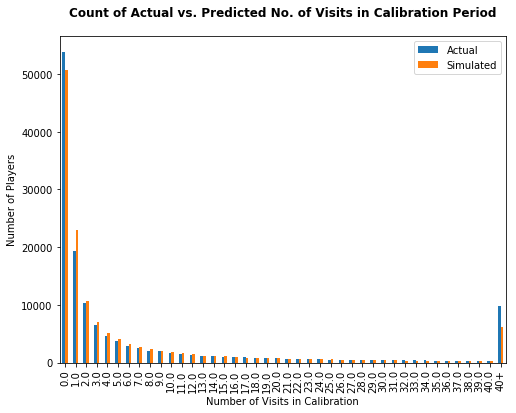

In [86]:
# Plot actual visits vs. simulated visits during calibration period under estimated bg/nbd model:

%matplotlib inline
bgnbd_actual_pred_cal_plot = cal_actual_sim_bgnbd.plot(kind = 'bar', figsize = (8,6))
bgnbd_actual_pred_cal_plot.set_title('Count of Actual vs. Predicted No. of Visits in Calibration Period',\
                                      fontweight = "bold", pad = 20)
bgnbd_actual_pred_cal_plot.legend(['Actual','Simulated'])
bgnbd_actual_pred_cal_plot.set_xticklabels(cal_actual_sim_bgnbd['visits'])[0]
bgnbd_actual_pred_cal_plot.set_xlabel('Number of Visits in Calibration')
bgnbd_actual_pred_cal_plot.set_ylabel('Number of Players')

    The plot above shows the simulation result of estimated model parameter in calibration period. 
    
    We then will see how the model predicts the patron visits during holdout period. 
    
    To plot holdout period fitness, we first need to generate predictions on number of visits each patron will make 
    in holdout period.

In [51]:
# Define function to generate data frame with actual frequency and predicted freqency at holdout period
# from original individual-level calibration and holdout summary data (customer by sufficient statistics, or CBS):

def generate_actual_pred_holdout_bgnbd(df):
    
    bgnbd_model = bgf.fit(df['frequency_cal'], df['recency_cal'], df['T_cal'])
    
    df['predict_holdout_bgnbd'] = bgnbd_model.predict(df['duration_holdout'],\
                                                      df['frequency_cal'],\
                                                      df['recency_cal'],\
                                                      df['T_cal'])
    df = df.reset_index()
    prediction = df.loc[:,['PlayerID','frequency_holdout','predict_holdout_bgnbd']]
    prediction['predict_holdout_bgnbd'] = prediction['predict_holdout_bgnbd'].fillna(0)
    prediction['predict_round_bgnbd'] = prediction['predict_holdout_bgnbd'].astype(int)
    
    return prediction

    The following table (just showing first five rows) contains information of the predicted number of visits each patron 
    will make during holdout period.
    
    With this information, we further plot the fitness of the BG/NBD model in holdout period.
    

In [52]:
# Generate predicted number of visits for each player during holdout period under BG/NBD:

predict_holdout_bgnbd = generate_actual_pred_holdout_bgnbd(CBS_BGNBD)
predict_holdout_bgnbd.head()

,PlayerID,frequency_holdout,predict_holdout_bgnbd,predict_round_bgnbd
0,100001,0.0,0.132173,0
1,100005,0.0,0.675793,0
2,100006,1.0,1.536230,1
3,100011,12.0,6.955938,6
4,100015,5.0,19.337787,19


In [53]:
# Generate table that counts the actual number and simulated number of patrons who made 
# 0, 1, 2, ..., 40+ repeat transactions during holdout period unde rBG/NBD Model:


holdout_actual_bgnbd = pd.DataFrame(predict_holdout_bgnbd["frequency_holdout"].value_counts().sort_index())\
                         .reset_index().rename(columns = {'index':'freq','frequency_holdout':'count'})
holdout_predict_bgnbd = pd.DataFrame(predict_holdout_bgnbd["predict_round_bgnbd"].value_counts().sort_index())\
                          .reset_index().rename(columns = {'index':'freq','predict_round_bgnbd':'count'})
    
hd_actual_bgnbd_binned = binned_max_freq(holdout_actual_bgnbd, 40)
hd_predict_bgnbd_binned = binned_max_freq(holdout_predict_bgnbd, 40)
    
hold_actual_pred_bgnbd = hd_actual_bgnbd_binned.merge(hd_predict_bgnbd_binned, how = 'outer', on = 'freq')
hold_actual_pred_bgnbd = hold_actual_pred_bgnbd.rename\
              (columns ={'freq':'visits' ,'count_x':'actual_counts','count_y':"predicted_counts"})

hold_actual_pred_bgnbd.head()

,visits,actual_counts,predicted_counts
0,0,77595,79086
1,1,15240,14113
2,2,8748,7952
3,3,5503,5594
4,4,3965,4120


    The following chunk of code is a combination of the functions defined above. It takes input of customer-by-
    sufficient-statistic matrix (CBS data frame) during calibration period, and an arbitrary maximum lower bound of number 
    of visits (for example, if we want to count the number of patrons who visited 40 times and above, then this maximum 
    number of visits is 40, and the output lower bound of maximum bin would be "40+"). This would output the same table 
    as the one above. 

In [54]:
# One-step function for holdout period BG/NBD model:
# Define function to generate table of actual and simulated counts of each visiting frequency, with input of dataframe CBS
# and an arbitrary maximum lower bound of number of visits:

def get_holdout_actual_pred_matrix_bgnbd(df, x_max):
    
    bgnbd_model = bgf.fit(df['frequency_cal'], df['recency_cal'], df['T_cal'])
    df['predict_holdout_bgnbd'] = bgnbd_model.predict(df['duration_holdout'],\
                                                    df['frequency_cal'],\
                                                    df['recency_cal'],\
                                                    df['T_cal'])
    df = df.reset_index()
    
    prediction = df.loc[:,['PlayerID','frequency_holdout','predict_holdout_bgnbd']]
    prediction['predict_holdout_bgnbd'] = prediction['predict_holdout_bgnbd'].fillna(0)
    prediction['predict_round_bgnbd'] = prediction['predict_holdout_bgnbd'].astype(int)
    
    holdout_actual_bgnbd = pd.DataFrame(prediction["frequency_holdout"].value_counts().sort_index())\
                            .reset_index().rename(columns = {'index':'freq','frequency_holdout':'count'})
    holdout_predict_bgnbd = pd.DataFrame(prediction["predict_round_bgnbd"].value_counts().sort_index())\
                            .reset_index().rename(columns = {'index':'freq','predict_round_bgnbd':'count'})
    
    hd_actual_bgnbd_binned = binned_max_freq(holdout_actual_bgnbd,x_max)
    hd_predict_bgnbd_binned = binned_max_freq(holdout_predict_bgnbd,x_max)
    
    hold_actual_pred_bgnbd = hd_actual_bgnbd_binned.merge(hd_predict_bgnbd_binned, how = 'outer', on = 'freq')
    hold_actual_pred_bgnbd = hold_actual_pred_bgnbd.rename\
                  (columns ={'freq':'visits' ,'count_x':'actual_counts','count_y':"predicted_counts"})
    
    return hold_actual_pred_bgnbd

hold_actual_pred_bgnbd_alt = get_holdout_actual_pred_matrix_bgnbd(CBS_BGNBD, 40)
hold_actual_pred_bgnbd_alt.head()

,visits,actual_counts,predicted_counts
0,0,77595,79086
1,1,15240,14113
2,2,8748,7952
3,3,5503,5594
4,4,3965,4120


Text(0, 0.5, 'Number of Players')

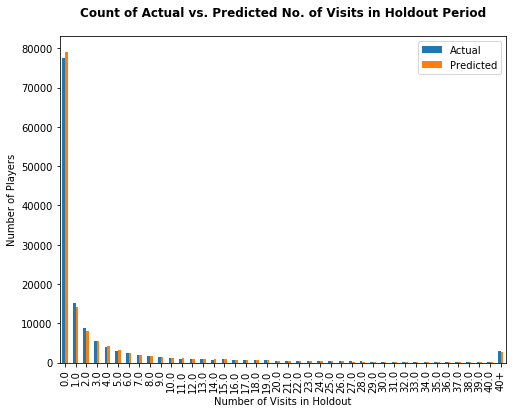

In [85]:
# Plot actual visits vs. simulated visits during holdout period:

%matplotlib inline
bgnbd_actual_pred_hold_plot = hold_actual_pred_bgnbd.plot(kind = 'bar', figsize = (8,6))
bgnbd_actual_pred_hold_plot.set_title('Count of Actual vs. Predicted No. of Visits in Holdout Period',\
                                      fontweight = "bold", pad = 20)
bgnbd_actual_pred_hold_plot.legend(['Actual','Predicted'])
bgnbd_actual_pred_hold_plot.set_xticklabels(hold_actual_pred_bgnbd['visits'])[0]
bgnbd_actual_pred_hold_plot.set_xlabel('Number of Visits in Holdout')
bgnbd_actual_pred_hold_plot.set_ylabel('Number of Players')

    The plot above shows the simulation result of estimated BG/NBD model parameter in holdout period. 
    
    We can see tha the prediction of number of patrons corresponding to each frequncy of visit is fairly good.

### Step 3: More visulizations under BG/NBD model

#### Plot 1: Plotting the heterogeneity of visiting rates. 
    
    This plot shows the distribution of visiting rates across patrons.

Text(45.125, 0.5, 'Density')

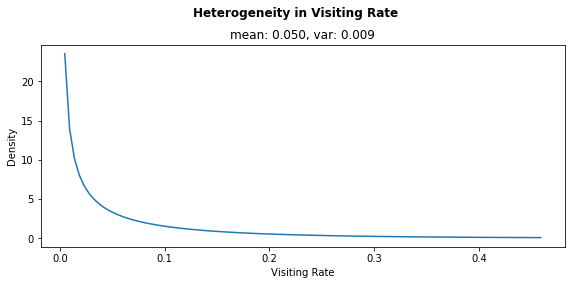

In [57]:
# Plot transaction rate heterogeneity curve:

%matplotlib inline

import matplotlib.pyplot as plt
import scipy
from scipy import *

r, alpha = bgnbd_model._unload_params("r", "alpha")
rate_mean = r / alpha
rate_var = r / alpha ** 2
rv = scipy.stats.gamma(r, scale=1 / alpha)
lim = rv.ppf(0.99)
x = np.linspace(0, lim, 100)

fig, ax = plt.subplots(figsize = (8,4))
fig.suptitle("Heterogeneity in Visiting Rate", fontweight="bold")
fig.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.plot(x, rv.pdf(x))

ax.set_title("mean: {:.3f}, var: {:.3f}".format(rate_mean, rate_var))
ax.set_xlabel('Visiting Rate')
ax.set_ylabel('Density')

#### Plot 2: Plotting the heterogeneity of dropout rates. 
    
    This plot shows the distribution of dropout rates across patrons.

Text(45.125, 0.5, 'Density')

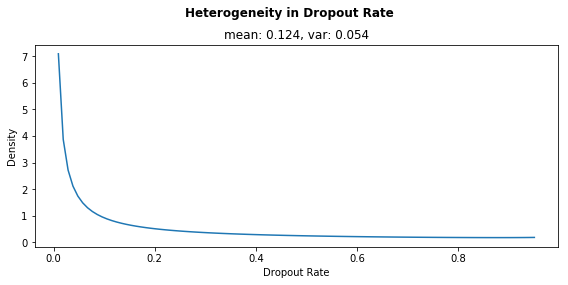

In [58]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy import *

a, b = bgnbd_model._unload_params("a", "b")
beta_mean = a / (a + b)
beta_var = a * b / ((a + b) ** 2) / (a + b + 1)

rv = scipy.stats.beta(a, b)
lim = rv.ppf(0.99)
x = np.linspace(0, lim, 100)

fig, ax = plt.subplots(figsize = (8,4))
fig.suptitle("Heterogeneity in Dropout Rate", fontweight = "bold")
fig.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.plot(x, rv.pdf(x))

ax.set_title("mean: {:.3f}, var: {:.3f}".format(beta_mean, beta_var))
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Density')

#### Plot 3: Plotting the expected number of visits

    This plot shows the expected number of visits in future t units of time (day in this case) for a patron with a 
    given "age", based on this patron's frequency and recency. 

    A patron's age means the units of time (day in our case) since the first observed visit during calibration 
    period (beginning 01/01/2018) until the end of calibration period (12/31/2018). 
    
    The following plot shows the expected number of purchases during holdout period (161 days, from 01/01/2019 to 
    06/10/2019), for a patron whose "age" is 300 days.

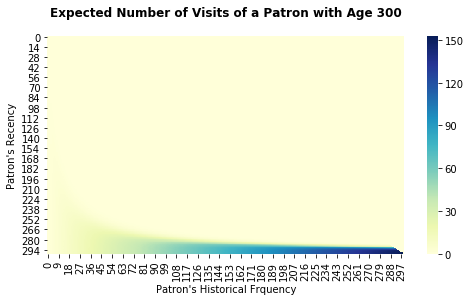

In [78]:
def plot_expected_future_visits_bgnbd(age, t):
    
    import matplotlib.pyplot as plt
    
    d = pd.DataFrame(np.zeros((age,age)))
    
    for i in range(age):
        for j in range(i):
            d.at[j,i] = bgf.predict(t, j, i, age)
    
    fig, ax = plt.subplots(figsize=(8,4))
    exp_future_visits = sns.heatmap(d.T,cmap = 'YlGnBu', ax = ax)
    exp_future_visits.set_title("Expected Number of Visits of a Patron with Age " + str(age), \
                                fontweight = "bold", pad = 20)
    exp_future_visits.set_xlabel("Patron's Historical Frquency")
    exp_future_visits.set_ylabel("Patron's Recency")
    
    
    return exp_future_visits

plot_expected_future_visits_bgnbd(300,161)

#### Plot 4: Plotting the conditional probability of alive
    
    This plot show the conditional probability that a patron of a given "age" is still "alive" (does not dropout) at 
    the end of the calibration period, based on this patron's frequency and recency.

    A patron's age means the units of time (day in our case) since the first observed visit during calibration 
    period (beginning 01/01/2018) until the end of calibration period (12/31/2018). 
    
    The following plot shows the probability of a patron whose "age" is 300 days being alive at the end of calibration
    period, based on this patron's frequency and recency.

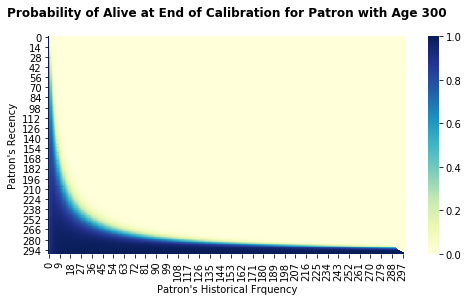

In [80]:
def plot_probability_alive_bgnbd(age):
    
    import matplotlib.pyplot as plt
    
    d = pd.DataFrame(np.zeros((age,age)))
    
    for i in range(age):
        for j in range(i):
            d.at[j,i] = bgnbd_model.conditional_probability_alive(j, i, age)
            
    fig, ax = plt.subplots(figsize=(8,4))
    prob_alive = sns.heatmap(d.T,cmap = 'YlGnBu', ax = ax)
    prob_alive.set_title("Probability of Alive at End of Calibration for Patron with Age " + str(age),\
                         fontweight = "bold", pad = 20)
    prob_alive.set_xlabel("Patron's Historical Frquency")
    prob_alive.set_ylabel("Patron's Recency")
    
    
    return prob_alive

plot_probability_alive_bgnbd(300)

#### Plot 5: Ploting holdout period actual visits vs. predicted visits

    This plot shows the corresponding average number of visits during holdout period for each actual number of visits 
    in calibration period.
    
    The blue line represents the actual average number of visits in holdout period.
    
    The orange line represents the predicted average number of visits in holdout period.

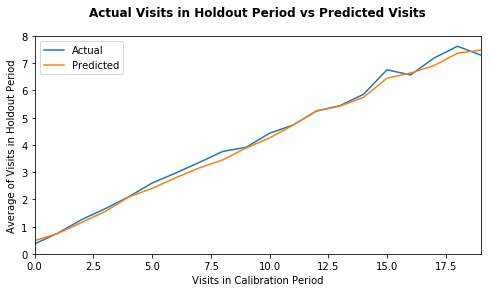

In [81]:
# Plot predicted average actual purchases in holdout period based on actual purchase in calibration under
# BG/NBD model:

%matplotlib inline
bgnbd_avg_holdout = plot_calibration_purchases_vs_holdout_purchases(bgnbd_model, CBS, n = 20, figsize = (8,4))
bgnbd_avg_holdout.set_title('Actual Visits in Holdout Period vs Predicted Visits',\
                            fontweight = "bold", pad = 20)
bgnbd_avg_holdout.set_xlabel('Visits in Calibration Period')
bgnbd_avg_holdout.set_ylabel('Average of Visits in Holdout Period')
bgnbd_avg_holdout.legend(['Actual','Predicted'])

## Part 3: Fitting a Pareto NBD (Pareto/NBD) Model 
    
    The pareto/NBD model is very similar the same as BG/NBD model. 
    Both models are good at predicting number of repeat transactions.
    The pareto/NBD model provides a similar fitting as the BG/NBD model.

### Step 1: Estimate Pareto/NBD Model parameters.¶

In [45]:
# Fitting Pareto/NBD Model:

pareto_model = pnf.fit(CBS['frequency_cal'], CBS['recency_cal'], CBS['T_cal'])
pareto_model

<lifetimes.ParetoNBDFitter: fitted with 137667 subjects, alpha: 9.30, beta: 1.49, r: 0.46, s: 0.10>

### Step 2: Assessing BG/NBD model fitness.

    Similar to what we did in BG/NBD model fitness assessment, we will first generate simulated data with estimated model
    parameters for calibration period visits and see how the model fits.
    
    We will count the number of patrons who made repeated number of visits of 0, 1, 2, 3, ..., 40, 40+ times during 
    calibration period repectively, and compare the actual counts to the simulated counts. A bar plot will be used to 
    visulize the comparison. 

In [63]:
# Simulate calibration visits based on estimated Pareto/NBD model parameters and count number of patrons at each 
# visit frequency:

simulated_pnbd = pnf.generate_new_data(size = len(CBS))
    
actual_cal_freq_pnbd = transform_cal_hold_to_freq_count(CBS)
simulated_cal_freq_pnbd = transform_sim_to_freq_count(simulated_pnbd)
    
actual_binned_pnbd = binned_max_freq(actual_cal_freq_pnbd, 40)
simulated_binned_pnbd = binned_max_freq(simulated_cal_freq_pnbd, 40)
    
cal_actual_pred_pnbd = actual_binned_pnbd.merge(simulated_binned_pnbd, how = 'outer', on = 'freq')
cal_actual_pred_pnbd = cal_actual_pred_pnbd.rename\
            (columns ={'freq':'visits' ,'count_x':'actual_counts','count_y':"simulated_counts"})
cal_actual_pred_pnbd['visits'] = cal_actual_pred_pnbd['visits'].astype(str)

cal_actual_pred_pnbd.head()

,visits,actual_counts,simulated_counts
0,0.0,53840,56935
1,1.0,19275,15735
2,2.0,10242,8880
3,3.0,6476,6466
4,4.0,4541,4933


Text(0, 0.5, 'Number of Players')

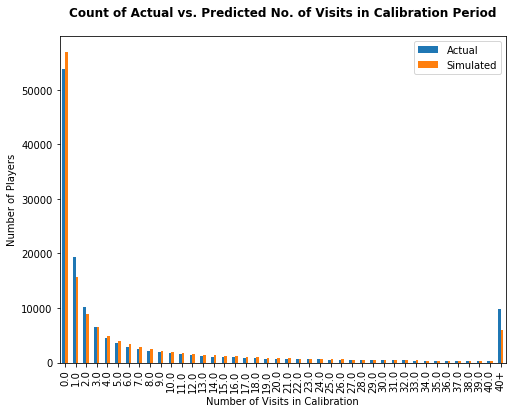

In [87]:
# Plot actual visits vs. simulated visits during calibration period under Pareto/NBD model:

%matplotlib inline
pnbd_actual_pred_cal_plot = cal_actual_pred_pnbd.plot(kind = 'bar', figsize = (8,6))
pnbd_actual_pred_cal_plot.set_title('Count of Actual vs. Predicted No. of Visits in Calibration Period',\
                                      fontweight = "bold", pad = 20)
pnbd_actual_pred_cal_plot.legend(['Actual','Simulated'])
pnbd_actual_pred_cal_plot.set_xticklabels(cal_actual_pred_pnbd['visits'])[0]
pnbd_actual_pred_cal_plot.set_xlabel('Number of Visits in Calibration')
pnbd_actual_pred_cal_plot.set_ylabel('Number of Players')

    The plot above shows the simulation result of estimated Pareto/NBD model parameter in calibration period. 
    We can see tha the calibration period fitting under Pareto/NBD model is similar to the fitting under BG/NBD model.
    
    As we did in BG/NBD model fitting assessment, we will see how the Pareto/NBD model fits the data in holdout period.
    We will generate a bar plot that visulizes comparison of the actual number of patrons who visited the casino 1,2,3,...,
    40,40+ times during holdout period.

In [65]:
# Generate table that counts the actual number and simulated number of patrons who made 
# 0, 1, 2, ..., 40+ repeat transactions during holdout period under Pareto/NBD model:

CBS_PNBD = CBS.copy()
CBS_PNBD['predict_holdout_pnbd'] = pareto_model.predict(CBS_PNBD['duration_holdout'],\
                                                        CBS_PNBD['frequency_cal'],\
                                                        CBS_PNBD['recency_cal'],\
                                                        CBS_PNBD['T_cal'])

pareto_prediction = CBS_PNBD.loc[:,['PlayerID','frequency_holdout','predict_holdout_pnbd']]
pareto_prediction['predict_holdout_pnbd'] = pareto_prediction['predict_holdout_pnbd'].fillna(0)
pareto_prediction['predict_round_pnbd'] = pareto_prediction['predict_holdout_pnbd'].astype(int)
    
holdout_actual_pnbd = pd.DataFrame(pareto_prediction["frequency_holdout"].value_counts().sort_index())\
                        .reset_index().rename(columns = {'index':'freq','frequency_holdout':'count'})
holdout_predict_pnbd = pd.DataFrame(pareto_prediction["predict_round_pnbd"].value_counts().sort_index())\
                        .reset_index().rename(columns = {'index':'freq','predict_round_pnbd':'count'})
    
hd_actual_pnbd_binned = binned_max_freq(holdout_actual_pnbd, 40)
hd_predict_pnbd_binned = binned_max_freq(holdout_predict_pnbd, 40)
    
hold_actual_pred_pnbd = hd_actual_pnbd_binned.merge(hd_predict_pnbd_binned, how = 'outer', on = 'freq')
hold_actual_pred_pnbd = hold_actual_pred_pnbd.rename\
             (columns ={'freq':'visits' ,'count_x':'actual_counts','count_y':"predicted_counts"})

hold_actual_pred_pnbd.head()

,visits,actual_counts,predicted_counts
0,0,77595,75739
1,1,15240,15351
2,2,8748,8477
3,3,5503,5850
4,4,3965,4729


Text(0, 0.5, 'Number of Players')

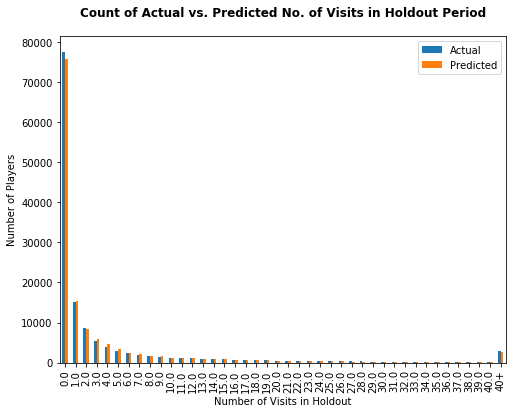

In [88]:
# Plot actual visits vs. simulated visits during holdout period under Pareto/NBD model:

%matplotlib inline
pnbd_actual_pred_hold_plot = hold_actual_pred_pnbd.plot(kind = 'bar', figsize = (8,6))
pnbd_actual_pred_hold_plot.set_title('Count of Actual vs. Predicted No. of Visits in Holdout Period',\
                                      fontweight = "bold", pad = 20)
pnbd_actual_pred_hold_plot.legend(['Actual','Predicted'])
pnbd_actual_pred_hold_plot.set_xticklabels(hold_actual_pred_pnbd['visits'])[0]
pnbd_actual_pred_hold_plot.set_xlabel('Number of Visits in Holdout')
pnbd_actual_pred_hold_plot.set_ylabel('Number of Players')

    The plot above shows the simulation result of estimated Pareto/NBD model parameter in holdout period. 
    
    We can see tha the prediction of number of patrons corresponding to each frequncy of visit is fairly good.

### Step 3: More visulizations under Pareto/NBD model

#### A series of visulization is generated under Pareto/NBD model. These visulizations are very similar to the ones generated under BG/NBD model.

#### Plot 1: Plotting the expected number of visits
    
    This plot shows the expected number of visits in future t units of time (day in this case) for a patron with a 
    given "age", based on this patron's frequency and recency. 

    A patron's age means the units of time (day in our case) since the first observed visit during calibration 
    period (beginning 01/01/2018) until the end of calibration period (12/31/2018). 
    
    The following plot shows the expected number of purchases during holdout period (161 days, from 01/01/2019 to 
    06/10/2019), for a patron whose "age" is 300 days.
    
    The actual plot under Pareto/NBD model is similar to the plot under BG/NBD model.

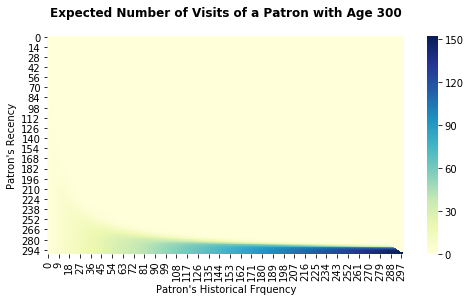

In [90]:
def plot_expected_future_visits_pareto(age, t):
    
    import matplotlib.pyplot as plt
    
    d = pd.DataFrame(np.zeros((age,age)))
    
    for i in range(age):
        for j in range(i):
            d.at[j,i] = pnf.predict(t, j, i, age)
    
    fig, ax = plt.subplots(figsize=(8,4))
    exp_future_visits = sns.heatmap(d.T,cmap = 'YlGnBu', ax = ax)
    exp_future_visits.set_title("Expected Number of Visits of a Patron with Age " + str(age),\
                                fontweight = "bold", pad = 20)
    exp_future_visits.set_xlabel("Patron's Historical Frquency")
    exp_future_visits.set_ylabel("Patron's Recency")
    
    
    return exp_future_visits

plot_expected_future_visits_pareto(300,161)

#### Plot 2: Plotting the conditional probability of alive

    This plot show the conditional probability that a patron of a given "age" is still "alive" (does not dropout) at 
    the end of the calibration period, based on this patron's frequency and recency.

    A patron's age means the units of time (day in our case) since the first observed visit during calibration 
    period (beginning 01/01/2018) until the end of calibration period (12/31/2018). 

    The following plot shows the probability of a patron whose "age" is 300 days being alive at the end of calibration
    period, based on this patron's frequency and recency.
    
    The actual plot under Pareto/NBD model is similar to the plot under BG/NBD model.

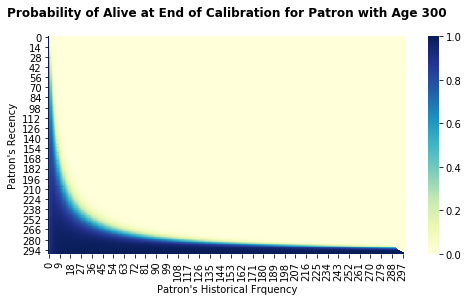

In [89]:
def plot_probability_alive_pnbd(age):
    
    import matplotlib.pyplot as plt
    
    d = pd.DataFrame(np.zeros((age,age)))
    
    for i in range(age):
        for j in range(i):
            d.at[j,i] = bgnbd_model.conditional_probability_alive(j, i, age)
            
    fig, ax = plt.subplots(figsize=(8,4))
    prob_alive = sns.heatmap(d.T,cmap = 'YlGnBu', ax = ax)
    prob_alive.set_title("Probability of Alive at End of Calibration for Patron with Age " + str(age),\
                         fontweight = "bold", pad = 20)
    prob_alive.set_xlabel("Patron's Historical Frquency")
    prob_alive.set_ylabel("Patron's Recency")
    
    
    return prob_alive

plot_probability_alive_pnbd(300)

#### Plot 3: Ploting holdout period actual visits vs. predicted visits

    This plot shows the corresponding average number of visits during holdout period for each actual number of visits 
    in calibration period.
    
    The blue line represents the actual average number of visits in holdout period.
    
    The orange line represents the predicted average number of visits in holdout period.
    
    The actual plot under Pareto/NBD model is similar to the plot under BG/NBD model.

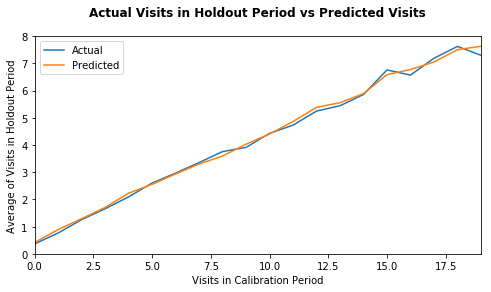

In [91]:
# Plot predicted average actual purchases in holdout period based on actual purchase in calibration under
# Pareto/NBD model:

%matplotlib inline

pnbd_avg_holdout = plot_calibration_purchases_vs_holdout_purchases(pareto_model, CBS, n = 20, figsize = (8, 4))
pnbd_avg_holdout.set_title('Actual Visits in Holdout Period vs Predicted Visits', fontweight = "bold", pad = 20)
pnbd_avg_holdout.set_xlabel('Visits in Calibration Period')
pnbd_avg_holdout.set_ylabel('Average of Visits in Holdout Period')
pnbd_avg_holdout.legend(['Actual','Predicted'])